## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from shapely import Point

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [3]:
script27_output_dir = accesibilidad_urbana + "data/external/santiago/output/"

## Load data

In [9]:
# red_buena_calidad (project_01)
baseline_hexproximity = gpd.read_file(script27_output_dir + "project_01/santiago_hexproximity_project_01.gpkg")
baseline_hexvariablesanalysis = gpd.read_file(script27_output_dir + "project_01/santiago_hexvariablesanalysis_project_01.gpkg")
baseline_hexanalysis = gpd.read_file(script27_output_dir + "project_01/santiago_hexanalysis_project_01.gpkg")

# red_buena_calidad_pza_italia (project_02)
plazaitalia_hexproximity = gpd.read_file(script27_output_dir + "project_02/santiago_hexproximity_project_02.gpkg")
plazaitalia_hexvariablesanalysis = gpd.read_file(script27_output_dir + "project_02/santiago_hexvariablesanalysis_project_02.gpkg")
plazaitalia_hexanalysis = gpd.read_file(script27_output_dir + "project_02/santiago_hexanalysis_project_02.gpkg")

# red_buena_calidad_norte_sur (project_03)
nortesur_hexproximity = gpd.read_file(script27_output_dir + "project_03/santiago_hexproximity_project_03.gpkg")
nortesur_hexvariablesanalysis = gpd.read_file(script27_output_dir + "project_03/santiago_hexvariablesanalysis_project_03.gpkg")
nortesur_hexanalysis = gpd.read_file(script27_output_dir + "project_03/santiago_hexanalysis_project_03.gpkg")

# red_buena_calidad_parque_bueras (project_04)
parquebueras_hexproximity = gpd.read_file(script27_output_dir + "project_04/santiago_hexproximity_project_04.gpkg")
parquebueras_hexvariablesanalysis = gpd.read_file(script27_output_dir + "project_04/santiago_hexvariablesanalysis_project_04.gpkg")
parquebueras_hexanalysis = gpd.read_file(script27_output_dir + "project_04/santiago_hexanalysis_project_04.gpkg")

In [10]:
print(baseline_hexproximity.crs)
print(baseline_hexvariablesanalysis.crs)
print(baseline_hexanalysis.crs)

EPSG:4326
EPSG:4326
EPSG:4326


## Data comparisons - Proximity

This cell compares the baseline proximity to any given project proximity and saves the result to a gdf. The gdf contains:
* The difference for each attribute in a column (for each hex).
* Whether there was a possitive (increase) or negative (decrease) change in ANY time or count column (for each hex).

__Result:__ There IS a problem. Some hexs (not those directly below project interventions/new node creations) registered more time before the project than after.

## Finding problem

Project_02(plaza italia) presents no problem, while Project_03(norte sur) and Project_04(parque bueras) have problems.

### Finding problem - Test 1: Is the network/code the problem? Or is the problem located in project_03 and project_04 specifically?

* __Approach:__ Re-do network process in QGIS for Project_00(baseline) and project_01(plaza_italia) and re-run __without changing code.__
* __Result:__ Re-doing the network and re-running plaza italia resulted in Plaza Italia having problems. But could also be the code, not the network.

### Finding problem - Test 2: Was the algorithm changed between projects?

* __Approach:__ Run Project_00(baseline) and project_01(plaza_italia) again __without changing anything (same old existing network)__ and re-test to see if problems emerge.
* __Result:__ Re-using the old network results in the correct result for Plaza Italia. __The problem is located in how the network is created.__

### Finding problem - Test 03: Invert QGIS process

#### Instead of:
1. __Split lines with lines__
2. __Vector > Geometry Tools > Multipart to singleparts__
3. Extract specific vertices [0,-1]
4. MMQGIS Modify > Drop dups
#### Do:
1. __Vector > Geometry Tools > Multipart to singleparts__
2. __Split lines with lines__
3. Extract specific vertices [0,-1]
4. MMQGIS Modify > Drop dups

__Result:__ "NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not"

### Finding problem - Testing site

In [8]:
def compare_proximity(baseline_hexproximity, comparing_project, comparison_id, save):
    # ----------
    attributes_list = ['carniceria_time','carniceria_count_15min','hogar_time','hogar_count_15min','bakeries_time','bakeries_count_15min',
                       'supermercado_time','supermercado_count_15min','banco_time','banco_count_15min','ferias_time','ferias_count_15min',
                       'local_mini_market_time','local_mini_market_count_15min','correos_time','correos_count_15min','centro_recyc_time','centro_recyc_count_15min',
                       'hospital_priv_time','hospital_priv_count_15min','hospital_pub_time','hospital_pub_count_15min','clinica_priv_time','clinica_priv_count_15min',
                       'clinica_pub_time','clinica_pub_count_15min','farmacia_time','farmacia_count_15min','vacunatorio_priv_time','vacunatorio_priv_count_15min',
                       'vacunatorio_pub_time','vacunatorio_pub_count_15min','consult_ado_priv_time','consult_ado_priv_count_15min','consult_ado_pub_time','consult_ado_pub_count_15min',
                       'salud_mental_time','salud_mental_count_15min','labs_priv_time','labs_priv_count_15min','residencia_adumayor_time','residencia_adumayor_count_15min',
                       'eq_deportivo_priv_time','eq_deportivo_priv_count_15min','eq_deportivo_pub_time','eq_deportivo_pub_count_15min','club_deportivo_time','club_deportivo_count_15min',
                       'civic_office_time','civic_office_count_15min','tax_collection_time','tax_collection_count_15min','social_security_time','social_security_count_15min',
                       'police_time','police_count_15min','bomberos_time','bomberos_count_15min','museos_priv_time','museos_priv_count_15min','museos_pub_time','museos_pub_count_15min',
                       'cines_time','cines_count_15min','sitios_historicos_time','sitios_historicos_count_15min','restaurantes_bar_cafe_time','restaurantes_bar_cafe_count_15min',
                       'librerias_time','librerias_count_15min','ep_plaza_small_time','ep_plaza_small_count_15min','ep_plaza_big_time','ep_plaza_big_count_15min',
                       'edu_basica_pub_time','edu_basica_pub_count_15min','edu_media_pub_time','edu_media_pub_count_15min','jardin_inf_pub_time','jardin_inf_pub_count_15min',
                       'universidad_time','universidad_count_15min','edu_tecnica_time','edu_tecnica_count_15min','edu_adultos_pub_time','edu_adultos_pub_count_15min',
                       'edu_especial_pub_time','edu_especial_pub_count_15min','bibliotecas_time','bibliotecas_count_15min','centro_edu_amb_time','centro_edu_amb_count_15min',
                       'paradas_tp_ruta_time','paradas_tp_ruta_count_15min','paradas_tp_metro_time','paradas_tp_metro_count_15min','paradas_tp_tren_time','paradas_tp_tren_count_15min',
                       'ciclovias_time','ciclovias_count_15min','estaciones_bicicletas_time','estaciones_bicicletas_count_15min']
    
    # ---------- Merge baseline and comparing project data
    both_gdfs = pd.merge(baseline_hexproximity,comparing_project[['hex_id']+attributes_list],on='hex_id')
    
    # ---------- Compare baseline (old) and project (new) attributes, saving the difference in a col and
    #            identifying hexs where time or count increased or decreased for any attribute.
    
    # Set to empty/0
    compare_list = []
    both_gdfs['time_increase'] = 0
    both_gdfs['time_decrease'] = 0
    both_gdfs['count_increase'] = 0
    both_gdfs['count_decrease'] = 0
    
    # Iterate over each attribute
    for attribute in attributes_list:
    
        # Find attribute difference
        old_attribute = f"{attribute}_x"
        new_attribute = f"{attribute}_y"
        both_gdfs[f"{attribute}_diff"] = both_gdfs[new_attribute] - both_gdfs[old_attribute]
    
        # Register positive or negative difference
        if 'time' in attribute:
            idx_1 = both_gdfs[f"{attribute}_diff"]>0
            both_gdfs.loc[idx_1,'time_increase'] = 1
            idx_2 = both_gdfs[f"{attribute}_diff"]<0
            both_gdfs.loc[idx_2,'time_decrease'] = 1
            
        elif 'count' in attribute:
            idx_3 = both_gdfs[f"{attribute}_diff"]>0
            both_gdfs.loc[idx_3,'count_increase'] = 1
            idx_4 = both_gdfs[f"{attribute}_diff"]<0
            both_gdfs.loc[idx_4,'count_decrease'] = 1
    
    # Save result
    if save:
        outputs_analysis_dir = accesibilidad_urbana + "data/external/santiago/outputs_analysis/"
        both_gdfs.to_file(outputs_analysis_dir + f"comparison_{comparison_id}_proximity_changes.gpkg", driver='GPKG')

In [33]:
baseline_hexproximity = gpd.read_file(script27_output_dir + "project_01/santiago_hexproximity_project_01.gpkg")

In [34]:
comparing_hexproximity = gpd.read_file(script27_output_dir + "project_02/santiago_hexproximity_project_02.gpkg")

In [35]:
compare_proximity(baseline_hexproximity,comparing_hexproximity,comparison_id='p01vsp02_04',save=True)

# COMPARISON IDS ALREADY EXPLORED:
# p01vsp02 --> Current situation (Works properly)
# p01vsp03 --> Current situation (Has undesired changes in proximity)
# p01vsp04 --> Current situation (Has undesired changes in proximity)

# Tests on p01(baseline) and p02(Plaza Italia, comparing):
# p01vsp02_01rerun --> Rerunning without changing anything test 
#                  --> Result is same as current situation (Both network and script work properly)

# p01vsp02_02redo --> Rerunning after redoing QGIS preprocessing steps 
#                 --> Result has undesired changes in proximity (QGIS preprocessing is the problem)

# p01vsp02_03reorder --> Changing the order with which QGIS preprocessing is done 
#                    --> Result has undesired changes in proximity (QGIS preprocessing may vary, not reliable)

# p01vsp02_04code --> Preprocess within script instead of in QGIS (Required recreating Nearest data)
#                 --> Result has a lot of undesired changes in proximity

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

### Finding problem - Test 04: Compare working (old) and non-working (re-done) networks.

In [71]:
networks_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/"

# red_buena_calidad_pza_italia (project_02)
project02_original_nodes = gpd.read_file(networks_dir + "02_red_buena_calidad_pza_italia/red_buena_calidad_pza_italia_nodes.shp")
project02_re_do_nodes = gpd.read_file(networks_dir + "02_red_buena_calidad_pza_italia/project_02_nodes.shp")

In [72]:
print(project02_original_nodes.shape)
print(project02_original_nodes.crs)
project02_original_nodes.head(1)

(14948, 10)
EPSG:32719


,fid,Nom_Rut,pje_ep,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1.0,Costanera Sur,0.549756,0,0,0,0,0.0,191.098679,POINT (350915.673 6302582.007)


In [73]:
print(project02_re_do_nodes.shape)
print(project02_re_do_nodes.crs)
project02_re_do_nodes.head(1)

(14949, 10)
EPSG:32719


,fid,Nom_Rut,pje_ep,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1.0,Costanera Sur,0.549756,0,0,0,0,0.0,191.098679,POINT (350915.673 6302582.007)


In [74]:
original_nodes_lst = list(project02_original_nodes.geometry.unique())
re_do_nodes_lst = list(project02_re_do_nodes.geometry.unique())

geoms_list = []
for geom in original_nodes_lst:
    if geom not in existing_nodes:
        geoms_list.append(geom)

geoms_list

[<POINT (348041.604 6299041.683)>,
 <POINT (348026.727 6299078.686)>,
 <POINT (347981.729 6299031.689)>,
 <POINT (348002.114 6299040.092)>,
 <POINT (348050.963 6299108.82)>,
 <POINT (347995.039 6299056.535)>,
 <POINT (347995.309 6299056.763)>,
 <POINT (348002.115 6299040.092)>,
 <POINT (348002.114 6299040.092)>,
 <POINT (347995.309 6299056.763)>,
 <POINT (348050.963 6299108.82)>,
 <POINT (348093.918 6299108.686)>]

In [ ]:
# Find that extra node
project02_re_do_nodes.loc[project02_re_do_nodes.geometry==Point(348041.6037999997, 6299041.6832)]

In [ ]:
# Find that extra node
project02_re_do_nodes.loc[project02_re_do_nodes.geometry==Point(348026.7271999996, 6299078.6865)]

In [ ]:
# Find nodes with differences between both processes
concat = pd.concat([project02_original_nodes,project02_re_do_nodes])
dropped = concat.drop_duplicates(keep=False)

dropped

In [ ]:
# Save resulting nodes
dropped.drop(columns='fid',inplace=True)
outputs_analysis_dir = accesibilidad_urbana + "data/external/santiago/outputs_analysis/"
dropped.to_file(outputs_analysis_dir+'project_02_different_nodes.gpkg', driver='GPKG')

# Plan B: Asking them to use OSMnx Network

## Load data

In [3]:
projected_crs = "EPSG:32719"

In [5]:
# aoi
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
city = 'alamedabuffer_4500m'

query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(aoi_gdf.crs)

epsg:4326


<Axes: >

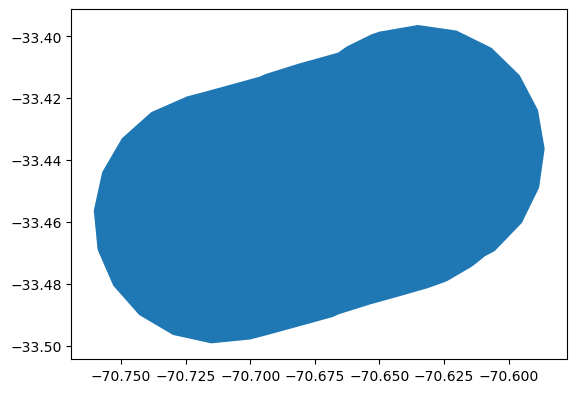

In [7]:
aoi_gdf.plot()

In [6]:
# osmnx_network
network_schema = 'projects_research'
nodes_table = 'santiago_nodes'
edges_table = 'santiago_edges'

G, nodes, edges = aup.graph_from_hippo(aoi_gdf, schema=network_schema, edges_folder=edges_table, nodes_folder=nodes_table, projected_crs=projected_crs)
print(nodes.crs)
print(edges.crs)

EPSG:4326
EPSG:4326


In [9]:
save = True
output_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/00_osmnx_nodata/"

In [11]:
print(nodes.shape)
nodes.head(1)

(43734, 4)


,x,y,street_count,geometry
osmid,,,,
386138,-70.646254,-33.442901,4,POINT (-70.64625 -33.44290)


In [12]:
print(edges.shape)
edges.head(1)

(114163, 15)


,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
u,v,key,,,,,,,,,,,,,,,
13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,"LINESTRING (-70.73850 -33.49002, -70.73804 -33...",None,None,None,None,None,None,None


In [10]:
if save:
    nodes.to_file(output_dir + f"nodes_buffer4500m.gpkg", driver='GPKG')
    edges.to_file(output_dir + f"edges_buffer4500m.gpkg", driver='GPKG')